In [ ]:

import numpy as np
import pandas as pd 
import seaborn as sns
import pandas_profiling as pd_profile

from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set(style="darkgrid", context="notebook", font_scale=0.7)
#plt.style.use("dark_background")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
raw_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])

In [ ]:
rename_map = {'sales': 'y', 'date': 'ds'}

df_agg_daily = raw_df.groupby(by='date').agg({'sales' : 'sum'}).reset_index().rename(columns=rename_map)
train_df = raw_df.rename(columns=rename_map)

# 1. EDA

## Basic season info using Prophet

In [ ]:
m = Prophet()
m.fit(df_agg_daily)

future = m.make_future_dataframe(periods= 3 * 30, freq='D')
forecast = m.predict(future)

fig = m.plot_components(forecast)

**Notes:**
1. Stable growth trend
2. Strong day-of-week seasonality
3. Strong month seasonality

## Part of total sales by STORE

In [ ]:
raw_df['year'] = raw_df.date.dt.year
store_sales = raw_df.groupby(by=['store', 'year']).agg({'sales': 'sum'}).reset_index()
item_sales = raw_df.groupby(by=['item', 'year']).agg({'sales': 'sum'}).reset_index()

In [ ]:
sns.lineplot(data=store_sales, x='year', y='sales', hue='store')

**Notes:** Part of sales by STORE seems very consistent. Thus allow to make one global model for all stores and use prediction:

*prediction_for_store = GLOBAL_PREDICTION * part_of_sales_of_store*

## Part of total sales by ITEM

In [ ]:
sns.lineplot(data=item_sales, x='year', y='sales', hue='item')

**Note:** Same store like in STORE - stable part-of-sales.

# 2. Forecasting

## Metrics

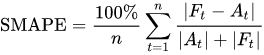

In [ ]:
# A, F - pd.Series
def calc_smape(A, F):
    return 2*((F - A).abs() / (A.abs() + F.abs())).mean()

In [ ]:
def train_test_split(raw_df):
    train_df = raw_df.loc[raw_df.date < '2017-09-01']
    test_df = raw_df.loc[raw_df.date  >= '2017-09-01']
    
    return train_df, test_df

## Baseline heuristic model 

**Aproach:** Common factors - growth trend, day of week season, monthly season. 

To predict sales on item=ITEM and store=STORE for date=DATE:

1. Extract from DATE -> DAY_OF_WEEK, MONTH
2. Find previous sales for ITEM at STORE with same MONTH and same DAY_OF_WEEK -> HISTORY
3. Calculate average percentage growth for HISTORY data points -> GROWTH_TREND
4. PREDICTED_VALUE = LAST_ITEM_FROM(HISTORY) * GROWTH_TREND

In [ ]:
raw_df['month'] = raw_df.date.dt.month
raw_df['weekday'] = raw_df.date.map(lambda x: x.weekday())

In [ ]:
train_df, test_df = train_test_split(raw_df)
indexed_train = train_df.set_index(['store', 'item'])

In [ ]:
def get_simple_prediction(df, store, item, date, silent=True):
    month = date.month
    weekday = date.weekday()
    
    history = df.loc[store, item]
    history = history.loc[(history.month == month) & (history.weekday==weekday)]
    
    mean_by_year = history.groupby(by=history.date.dt.year).agg('mean')
    mean_by_year['sales_growth'] = mean_by_year['sales'].pct_change()
    
    
    mean_growth = mean_by_year['sales_growth'].mean()
    predicted_value = mean_by_year.sales.iloc[-1] * (1 + mean_growth)
    
    if not silent:
        print(mean_by_year)
        print('mean_growth={0:.2%} predicted sales={1:.2f}'.format(mean_growth, predicted_value))
    return predicted_value

In [ ]:
get_simple_prediction(indexed_train, 2, 5, pd.to_datetime('2020-07-28'), silent=False)

In [ ]:
from tqdm import tqdm

tqdm.pandas()

#forecast = test_df.reset_index().progress_apply(lambda x: get_simple_prediction(indexed_train, store=x['store'], item=x['item'], date=x['date']), axis=1)

# F = forecast
# A = test_df.reset_index().sales

# calc_smape(A, F)

**Notes:** 15.14 SMAPE for simple heuristic - not bad at all! Best score at leaderboard - 12.58

# Forecasting - Prophet. Custom model for each item-store

In [ ]:
import gc
from IPython.core.debugger import set_trace

def predict_test_data(train_df, test_df):
    test_res = test_df.copy().set_index(['store', 'item', 'date'])
    indexed_train = train_df.set_index(['store', 'item'])
    
    processed = 0

    store_items_pairs = indexed_train.index.unique()
    for store, item in store_items_pairs:
        df = indexed_train.loc[(store, item)].rename(columns=rename_map)[['ds', 'y']]

        # Fit
        m = Prophet()
        m.fit(df)

        # Predict
        test_period = len(test_res.loc[(store, item)])

        future = m.make_future_dataframe(periods=test_period, freq='D', include_history=False)
        forecast = m.predict(future)

        #set_trace()
        # Save forecast
        for date, fcst in forecast.set_index('ds')['yhat'].iteritems():
            test_res.loc[(store, item, date), 'forecast'] = fcst

#         del m
         
#         if processed % 10 == 0:
#             gc.collect()
        
        processed+=1
        print('Processed {0} of {1}'.format(processed, len(store_items_pairs)))
        
    return test_res

In [ ]:
# test_res = predict_test_data(train_df, test_df)
# res = test_res.loc[~test_res.forecast.isna()]

# A = res.reset_index().sales
# F = res.reset_index().forecast

# calc_smape(A, F)

**Notes:** 0.1281 SMAPE for simplies Prophet usage. Nice results, lets try to check on submission.

In [ ]:
#submission_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
#submission_res_df = predict_test_data(raw_df, submission_df)
#submission_res_df.reset_index()[['id', 'forecast']].rename(columns={'forecast': 'sales'}).to_csv('submission.csv', index=False)

## Forecasting - Prophet. One model per each item (but shared model for each store)

**Check part-of-market of each store consistency**

In [ ]:
df_gr_by_store_2015 = raw_df.loc[raw_df.year==2015].groupby(by='store').agg({'sales': 'sum'})
df_gr_by_store_2015['part_of_market'] = df_gr_by_store_2015['sales'] / df_gr_by_store_2015['sales'].sum()

df_gr_by_store_2017 = raw_df.loc[raw_df.year==2017].groupby(by='store').agg({'sales': 'sum'})
df_gr_by_store_2017['part_of_market'] = df_gr_by_store_2017['sales'] / df_gr_by_store_2017['sales'].sum()

consis_res = df_gr_by_store_2017.join(df_gr_by_store_2015, lsuffix='_2017', rsuffix='_2015')
consis_res['diff'] = (consis_res['part_of_market_2017'] - consis_res['part_of_market_2015']) / consis_res['part_of_market_2015']
consis_res

In [ ]:
store_part_of_market_dict = consis_res['part_of_market_2017']
store_part_of_market_dict

**Notes:** Great results - highly consistent data for store part-of-market

In [ ]:
train_item_df, test_item_df = train_test_split(raw_df)
train_item_df = train_item_df.groupby(by=['item', 'date']).agg({'sales': 'sum'}).reset_index()
ALL_STORES = raw_df.store.unique()

In [ ]:
def predict_test_data_for_item(train_item_df, test_item_df):
    test_res = test_item_df.copy().set_index(['store', 'item', 'date'])
    indexed_train = train_item_df.set_index(['item'])
    
    processed = 0

    for item in indexed_train.index.unique():
        df = indexed_train.loc[item].rename(columns=rename_map)[['ds', 'y']]

        # Fit
        m = Prophet()
        m.fit(df)

        # Predict
        test_period = len(test_res.loc[1, 1])

        future = m.make_future_dataframe(periods=test_period, freq='D', include_history=False)
        forecast = m.predict(future)

        # Save forecast
        for date, fcst_for_item in forecast.set_index('ds')['yhat'].iteritems():
            for store in ALL_STORES:
                part_of_store = store_part_of_market_dict.loc[store]
                fcst = fcst_for_item * part_of_store
            
                test_res.loc[(store, item, date), 'forecast'] = fcst

        
        processed+=1
        print('Processed {0} of {1}'.format(processed, len(indexed_train.index.unique())))
        
    return test_res

In [ ]:
# test_res = predict_test_data_for_item(train_item_df, test_item_df)

# A = test_res.reset_index().sales
# F = test_res.reset_index().forecast

# calc_smape(A, F)

0.1264 smape - improvement compared to one-mode-per-each-item-and-store

In [ ]:
submission_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
submission_res_df = predict_test_data_for_item(raw_df, submission_df)
submission_res_df.reset_index()[['id', 'forecast']].rename(columns={'forecast': 'sales'}).to_csv('submission.csv', index=False)